<a href="https://colab.research.google.com/github/madhumilan/DL-in-Computer-Vision/blob/main/TransferLearningWResnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transfer Learning**

This notebook performa transfer learning to train CIFAR-10 dataset on ResNet50 model available in Keras.

**Imports**

In [11]:
import os, re, json, time
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


Define the batch size and class names

In [12]:
BATCH_SIZE = 32
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Some visualization functions

In [13]:
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# utility to display a row of digits with their predictions
def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]
 
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]
    
    plt.xlabel(classes[class_index])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])

# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

## **Loading and Preprocessing Data**

CIFAR-10 dataset has 32 x 32 RGB images belonging to 10 classes. You will load the dataset from Keras.

In [14]:
(training_images, training_labels), (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

**Visualize dataset**

Use the above visualization function to view some of the images and labels

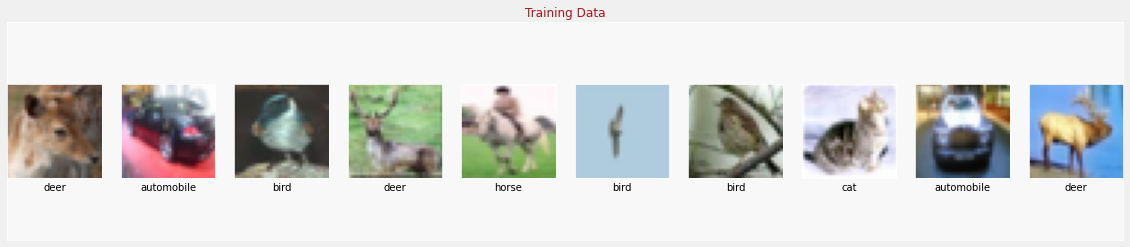

In [15]:
display_images(training_images, training_labels, training_labels, "Training Data")

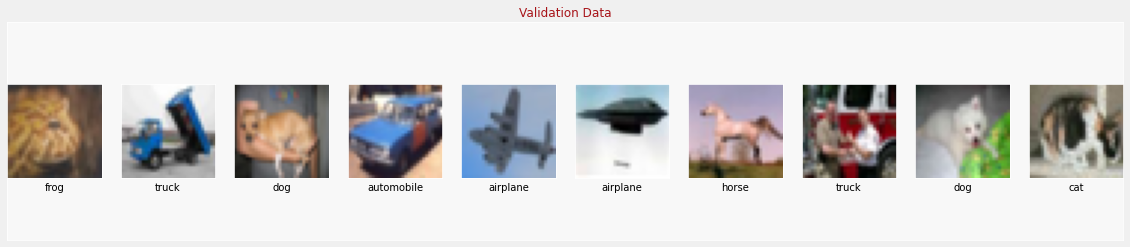

In [16]:
display_images(validation_images, validation_labels, validation_labels, "Validation Data")

**Preprocess dataset**

Perform normalization on images (training and validation set)
Use preprocess_input fuction from ResNet50 model in Keras

In [17]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims

In [18]:
train_x = preprocess_image_input(training_images)
valid_x = preprocess_image_input(validation_images)

### **Define the network**

Perform Transfer Learning on ResNet50 model in Keras


*   Load pre-trained image-net weights to the model
*   Choose to retain all layers of ResNet50 along with the final classification layers



In [19]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights. 
Input size is 224 x 224.
'''
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor

'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Define the model and compile it. 
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model

model = define_compile_model()

model.summary()

94773248/94765736 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
______________________________________________________________

### **Train the Model**



In [20]:
EPOCHS = 4
history = model.fit(train_x, training_labels, epochs=EPOCHS, validation_data=(valid_x, validation_labels), batch_size=64)

Epoch 1/4
782/782 [==============================] - 565s 674ms/step - loss: 0.7318 - accuracy: 0.7621 - val_loss: 0.2448 - val_accuracy: 0.9186
Epoch 2/4
782/782 [==============================] - 535s 684ms/step - loss: 0.1042 - accuracy: 0.9659 - val_loss: 0.2151 - val_accuracy: 0.9314
Epoch 3/4
782/782 [==============================] - 534s 683ms/step - loss: 0.0376 - accuracy: 0.9896 - val_loss: 0.1692 - val_accuracy: 0.9509
Epoch 4/4
782/782 [==============================] - 534s 683ms/step - loss: 0.0139 - accuracy: 0.9971 - val_loss: 0.1697 - val_accuracy: 0.9513


**Evaluate the model**

In [21]:
loss, accuracy = model.evaluate(valid_x, validation_labels, batch_size=64)

157/157 [==============================] - 31s 199ms/step - loss: 0.1697 - accuracy: 0.9513


### **Plot Loss and Accuracy curves**

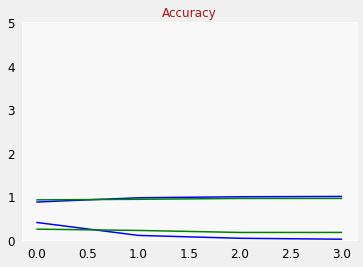

In [22]:
plot_metrics('loss', 'Loss')

plot_metrics('accuracy', 'Accuracy')

**Visualize Predictions**

In [23]:
probabilities = model.predict(valid_x, batch_size=64)
probablitites = np.argmax(probabilities, axis=1)

display_images(validation_images, probabilities, validation_labels, "Bad predictions indicated in red.")

ValueError: ignored